In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import requests
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(0)

In [ ]:
%matplotlib inline

# **Classification Model - CNN**

## Load Data

In [ ]:
with open('/content/drive/MyDrive/TSRC/Dataset/train_dataset.pickle', 'rb') as f:
  train_data = pickle.load(f)
with open('/content/drive/MyDrive/TSRC/Dataset/val_dataset.pickle', 'rb') as f:
  val_data = pickle.load(f)
with open('/content/drive/MyDrive/TSRC/Dataset/test_dataset.pickle', 'rb') as f:
  test_data = pickle.load(f)

x_train, y_train = train_data['images'], train_data['labels']
x_val, y_val = val_data['images'], val_data['labels']
x_test, y_test = test_data['images'], test_data['labels']

In [ ]:
print(f"Length of train: {x_train.shape[0]}")
print(f"Length of validation: {x_val.shape[0]}")
print(f"Length of test: {x_test.shape[0]}")

Length of train: 13698
Length of validation: 3173
Length of test: 4219


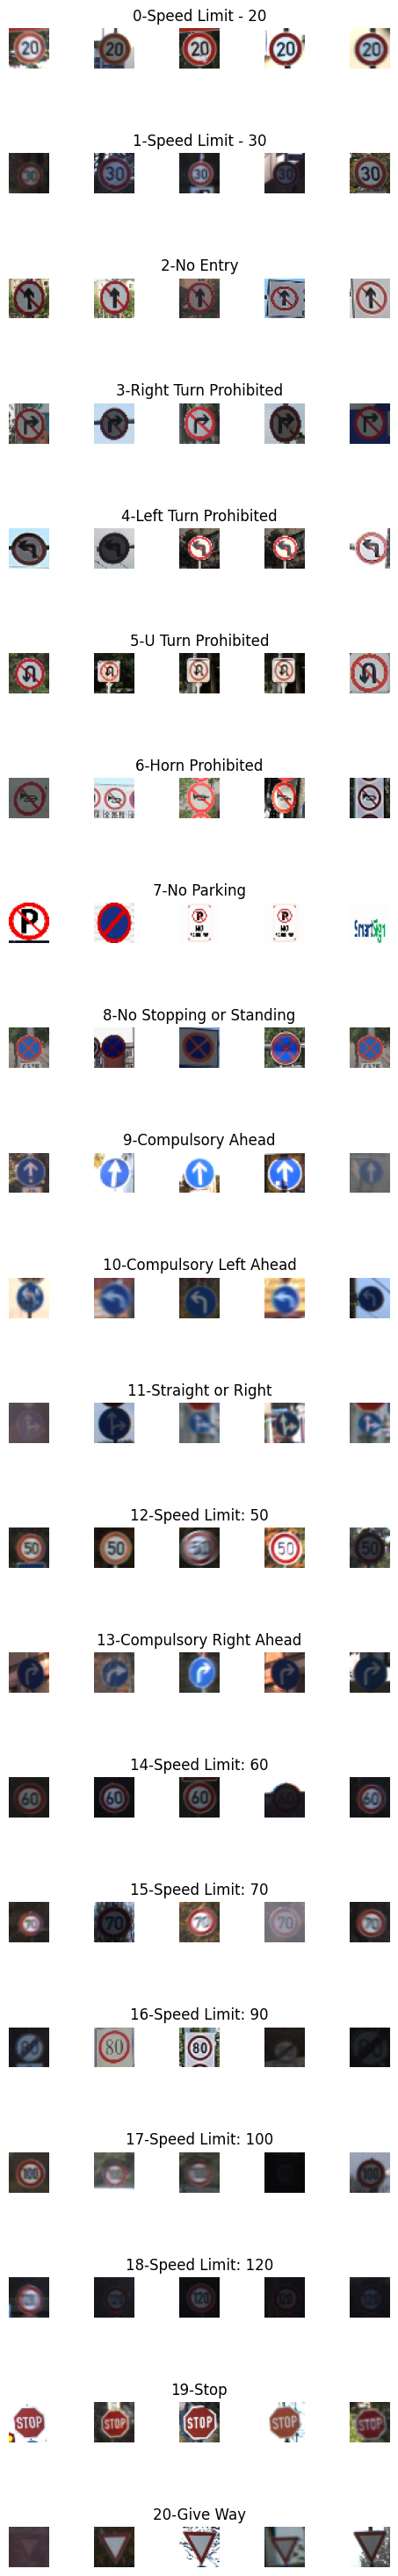

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TSRC/CNN/Indian_datasets.csv')

num_of_samples = []

cols = 5
num_classes = 21

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 30))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Sign Name"])
            num_of_samples.append(len(x_selected))

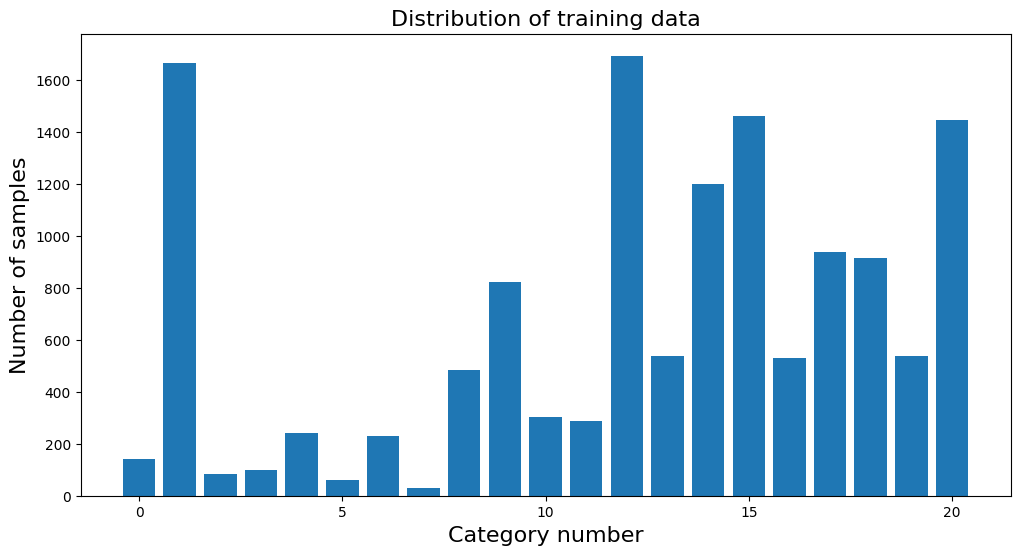

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of training data", fontsize=16)
plt.xlabel("Category number", fontsize=16)
plt.ylabel("Number of samples", fontsize=16)
plt.show()

## Image Processing

Image shape: (32, 32, 3)
Category number: 1



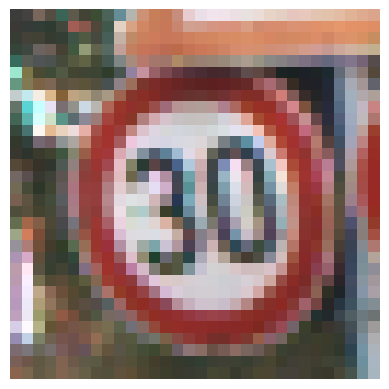

In [ ]:
plt.imshow(x_train[1000])
plt.axis("off")
print(f"Image shape: {x_train[1000].shape}")
print(f"Category number: {y_train[1000]}\n")

Shape after grayscale: (32, 32)



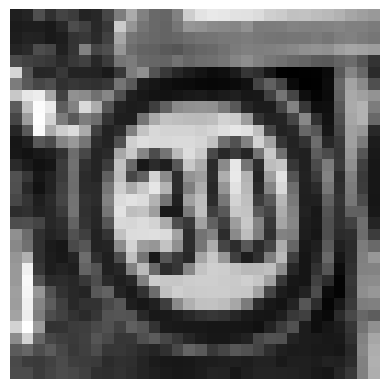

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(x_train[1000])
plt.imshow(img, cmap='gray')
plt.axis("off")
print(f"Shape after grayscale: {img.shape}\n")

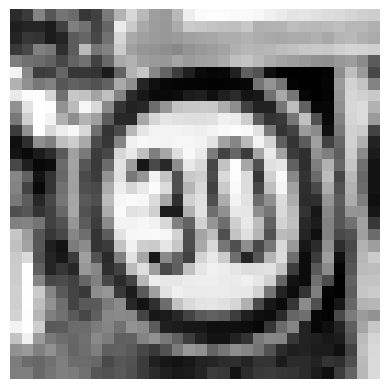

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
def preporocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

x_train = np.array(list(map( preporocessing, x_train)))
x_val = np.array(list(map( preporocessing, x_val)))
x_test = np.array(list(map( preporocessing, x_test)))

Shape of training dataset: (13698, 32, 32)



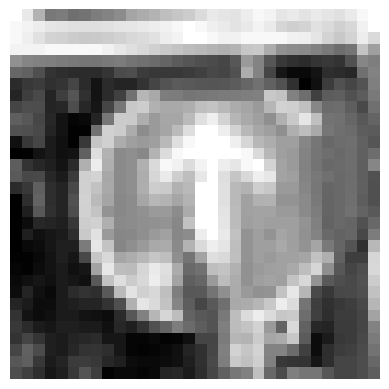

In [ ]:
plt.imshow(x_train[random.randint(0, len(x_train) - 1)], cmap='gray')
plt.axis("off")
print(f"Shape of training dataset: {x_train.shape}\n")

In [ ]:
x_train = x_train.reshape(13698, 32, 32, 1)
x_test = x_test.reshape(4219, 32, 32, 1)
x_val = x_val.reshape(3173, 32, 32, 1)

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(x_train)

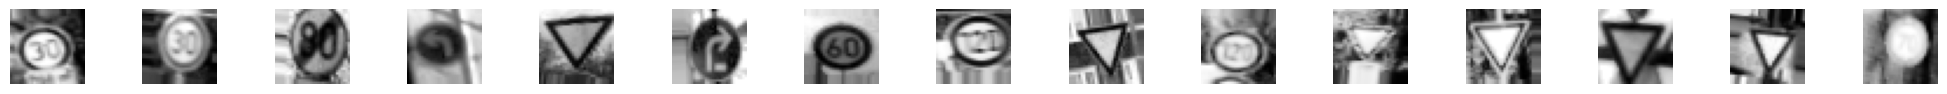

In [ ]:
batches = datagen.flow(x_train, y_train, batch_size=256)
x_batch, y_batch = next(batches)


fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32, 32), cmap='gray')
  axs[i].axis('off')

In [ ]:
y_train = to_categorical(y_train, 21)
y_test = to_categorical(y_test, 21)
y_val = to_categorical(y_val, 21)

## Classification Model

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=10, validation_data=(x_val, y_val), shuffle = 1)

Epoch 1/10
215/215 [==============================] - 18s 30ms/step - loss: 2.6229 - accuracy: 0.1627 - val_loss: 2.0272 - val_accuracy: 0.3501
Epoch 2/10
215/215 [==============================] - 6s 30ms/step - loss: 1.6072 - accuracy: 0.4325 - val_loss: 1.3952 - val_accuracy: 0.5137
Epoch 3/10
215/215 [==============================] - 5s 25ms/step - loss: 0.8451 - accuracy: 0.7162 - val_loss: 0.6747 - val_accuracy: 0.7929
Epoch 4/10
215/215 [==============================] - 7s 31ms/step - loss: 0.4245 - accuracy: 0.8671 - val_loss: 0.6316 - val_accuracy: 0.8030
Epoch 5/10
215/215 [==============================] - 5s 25ms/step - loss: 0.2956 - accuracy: 0.9079 - val_loss: 0.6749 - val_accuracy: 0.8333
Epoch 6/10
215/215 [==============================] - 7s 31ms/step - loss: 0.2358 - accuracy: 0.9264 - val_loss: 0.6557 - val_accuracy: 0.8342
Epoch 7/10
215/215 [==============================] - 5s 25ms/step - loss: 0.1931 - accuracy: 0.9415 - val_loss: 0.7556 - val_accuracy: 0.822

## Training Results

In [ ]:
labelNames = open("/content/drive/MyDrive/TSRC/CNN/Indian_datasets.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

predictions = model.predict(x_val, batch_size=64)
print(classification_report(y_val.argmax(axis=1),	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
50/50 [==============================] - 1s 8ms/step
                         precision    recall  f1-score   support

       Speed Limit - 20       0.40      0.97      0.56        33
       Speed Limit - 30       0.88      0.96      0.91       385
               No Entry       0.83      0.95      0.88        20
  Right Turn Prohibited       0.20      1.00      0.33        24
   Left Turn Prohibited       0.95      1.00      0.97        56
      U Turn Prohibited       0.28      0.50      0.36        14
        Horn Prohibited       0.72      0.25      0.37        53
             No Parking       0.00      0.00      0.00         7
No Stopping or Standing       0.74      1.00      0.85       112
       Compulsory Ahead       0.99      0.97      0.98       190
  Compulsory Left Ahead       0.91      0.86      0.88        70
      Straight or Right       0.95      0.82      0.88        67
        Speed Limit: 50       0.96      0.87      0.92       391
 Compul

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


132/132 [==============================] - 1s 4ms/step


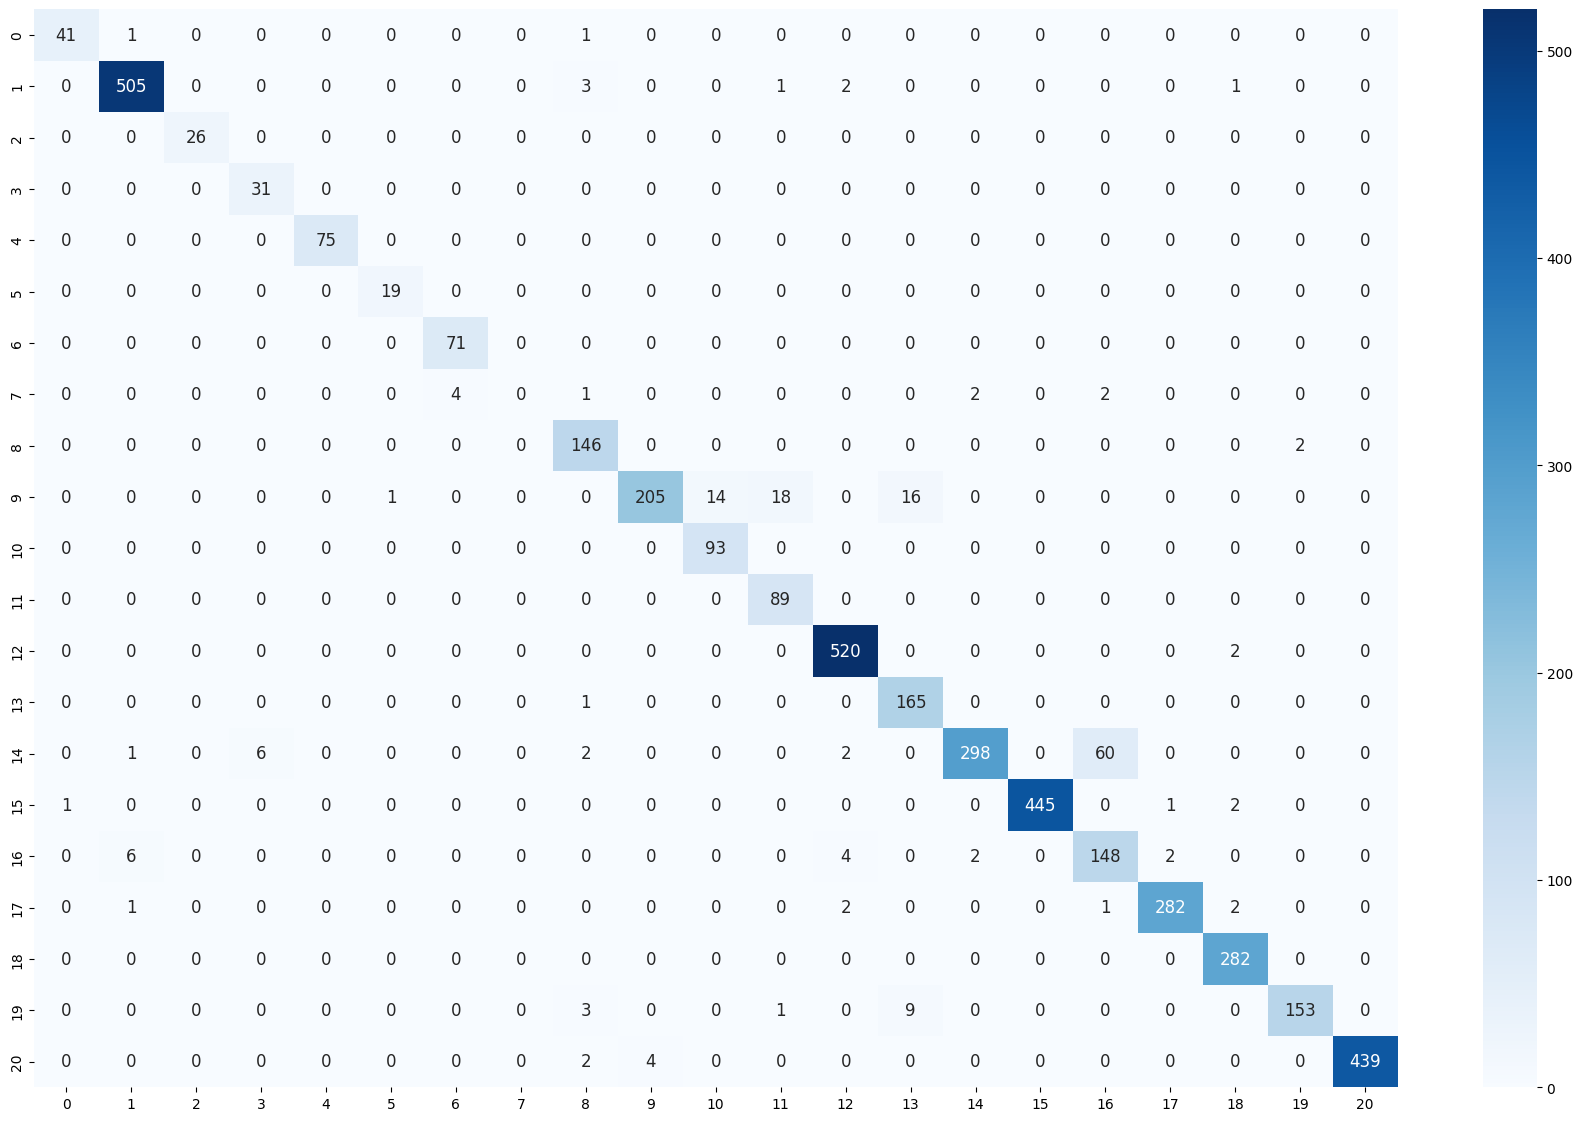

In [ ]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (22, 14))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={'size':12})
plt.show()

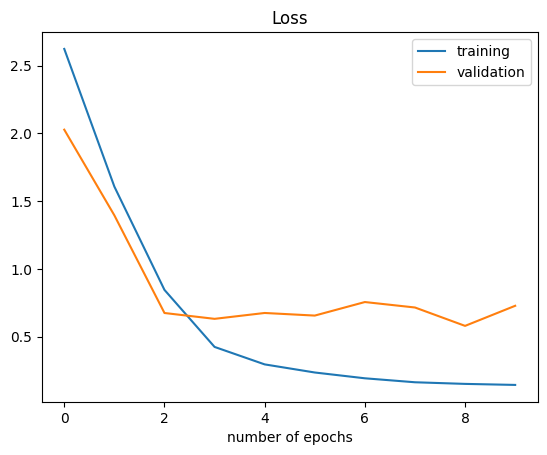

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('number of epochs')
plt.show()

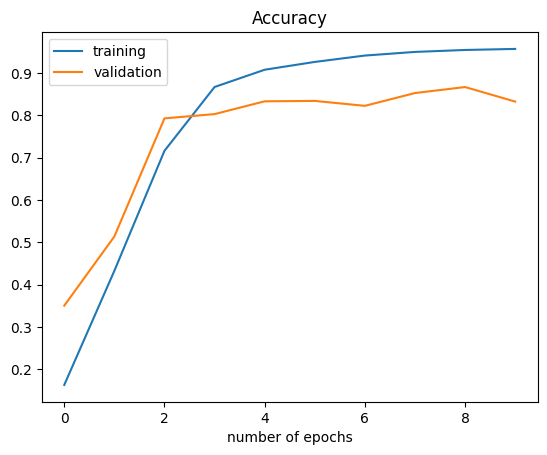

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('number of epochs')
plt.show()

In [ ]:
x_test.shape

(4219, 32, 32, 1)

In [ ]:
y_test.shape

(4219,)

In [ ]:
print('-Acuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(y_test,y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

-Acuracy achieved: 95.59%
-Accuracy by model was: 95.71%
-Accuracy by validation was: 83.27%


## Test Classification Model

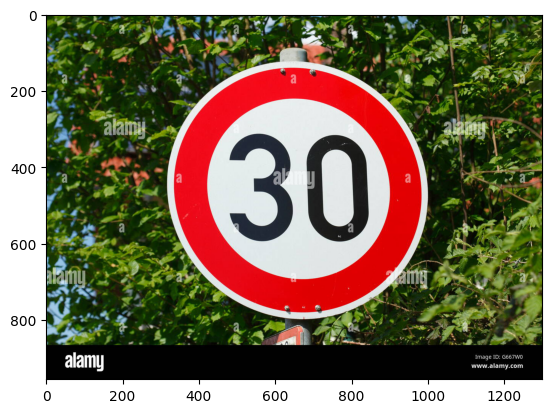

In [ ]:
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg' #speed limit 30 [1]

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img)
plt.show()

Shape after preprocessing: (32, 32)



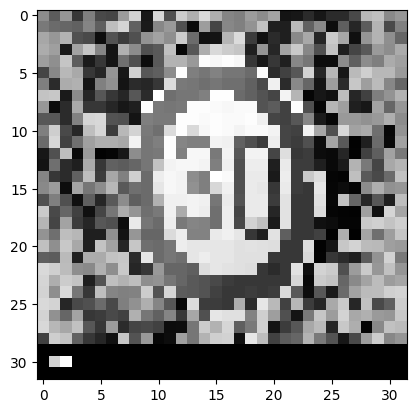

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preporocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(f"Shape after preprocessing: {img.shape}\n")

In [ ]:
img = img.reshape(1, 32, 32, 1)

In [ ]:
print("Category number of predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 212ms/step
Category number of predicted sign: [1]


# **Detection Model - YOLO**

In [ ]:
%cd '/content/drive/MyDrive/TSRC/'

/content/drive/MyDrive/TSRC


In [ ]:
!chmod +x ./darknet

In [ ]:
# Train YOLO
!./darknet detector demo /content/drive/MyDrive/TSRC/darknet/cfg/ts_data.data /content/drive/MyDrive/TSRC/darknet/cfg/yolov3_ts_test.cfg /content/drive/MyDrive/TSRC/darknet/backup/yolov3.weights /content/drive/MyDrive/TSRC/test_video2.mp4 -thresh 0.5 -result /content/drive/MyDrive/TSRC/result2.mp4 -dont_show

/bin/bash: ./darknet: Is a directory


In [ ]:
!ls darknet/backup

yolov3.weights	yolov4_tsb_train_best.weights  yolov4.weights


In [ ]:
# Load weights
path_to_weights = '/content/drive/MyDrive/TSRC/darknet/backup/yolov3.weights'
# Load configuration file
path_to_cfg = '/content/drive/MyDrive/TSRC/darknet/cfg/yolov3_ts_test.cfg'

network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)

network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)

In [ ]:
layers_all = network.getLayerNames()
layers_names_output = [layers_all[i - 1] for i in network.getUnconnectedOutLayers()]

#**Recognition of Traffic Signs in Video File**

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/TSRC/CNN/Indian_datasets.csv')

In [ ]:
probability_minimum = 0.6
threshold = 0.2
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [ ]:
video = cv2.VideoCapture('/content/drive/MyDrive/TSRC/test_video2.mp4')
writer = None
h, w = None, None

In [ ]:
plt.rcParams['figure.figsize'] = (3, 3)
f = 0
t = 0


while True:
    ret, frame = video.read()
    if not ret:
        break

    if w is None or h is None:
        h, w = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (800, 800), swapRB=True, crop=False)

    network.setInput(blob)
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()

    f += 1
    t += end - start

    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]

            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                c_ts = np.asarray(c_ts)
                c_ts = cv2.resize(c_ts, (32, 32))
                c_ts = preporocessing(c_ts)
                c_ts = c_ts.reshape(1, 32, 32, 1)

                scores = model.predict(c_ts)
                prediction = np.argmax(scores)
                color_box_current = colours[class_numbers[i]].tolist()

                cv2.rectangle(frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              color_box_current, 2)

                text_box_current = '{}: {:.4f}'.format(labels['Sign Name'][prediction], confidences[i])

                cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_box_current, 2)


    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter('/content/drive/MyDrive/TSRC/result2.mp4', fourcc, 25,
                                 (frame.shape[1], frame.shape[0]), True)
    writer.write(frame)

video.release()
writer.release()

Frame number 1 took 4.31269 seconds
1/1 [==============================] - 0s 22ms/step
Frame number 2 took 2.48896 seconds
Frame number 3 took 2.46248 seconds
1/1 [==============================] - 0s 20ms/step
Frame number 4 took 2.94796 seconds
1/1 [==============================] - 0s 28ms/step
Frame number 5 took 3.01954 seconds
1/1 [==============================] - 0s 22ms/step
Frame number 6 took 2.52340 seconds
1/1 [==============================] - 0s 20ms/step
Frame number 7 took 2.47825 seconds
Frame number 8 took 2.49119 seconds
Frame number 9 took 3.51848 seconds
1/1 [==============================] - 0s 22ms/step
Frame number 10 took 2.47107 seconds
1/1 [==============================] - 0s 22ms/step
Frame number 11 took 2.48871 seconds
1/1 [==============================] - 0s 20ms/step
Frame number 12 took 2.51198 seconds
1/1 [==============================] - 0s 19ms/step
Frame number 13 took 2.78203 seconds
1/1 [==============================] - 0s 30ms/step
Frame nu